In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from math import sqrt
from collections import Counter
import time

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

ROOT = Path(r"C:\DOCTORAL HUB\nmr_pipeline_project")

# Input: merged mapping file from Phase 3
merged_path = ROOT / "data" / "merged" / "merged_phase3_clean.csv"
df = pd.read_csv(merged_path)

print("Loaded merged data:", merged_path)
print("Rows:", len(df))
print("Columns:", df.columns.tolist()[:15], "...")

Loaded merged data: C:\DOCTORAL HUB\nmr_pipeline_project\data\merged\merged_phase3_clean.csv
Rows: 434147
Columns: ['mol_idx', 'atom_index', 'element_x', 'shift_ppm_x', 'element_y', 'shift_ppm_y', 'hose_1', 'hose_2', 'hose_3', 'hose_4', 'bit_0', 'bit_1', 'bit_2', 'bit_3', 'bit_4'] ...


In [2]:
# TODO: adjust this path/filename if yours is different
mol_table_path = ROOT / "data" / "curated" / "molecules.csv"

mol_df = pd.read_csv(mol_table_path)
print("Loaded molecule table:", mol_table_path)
print(mol_df.columns.tolist()[:10])
print("Number of molecules:", len(mol_df))

# normalize columns to known names
possible_smiles_cols = [c for c in mol_df.columns if "smiles" in c.lower()]
if "smiles" in mol_df.columns:
    smiles_col = "smiles"
elif "canonical_smiles" in mol_df.columns:
    smiles_col = "canonical_smiles"
elif len(possible_smiles_cols) == 1:
    smiles_col = possible_smiles_cols[0]
else:
    smiles_col = possible_smiles_cols[0] if possible_smiles_cols else None

if smiles_col is None:
    raise RuntimeError(" Could not find a SMILES column in molecule table. Please tell me the column name.")

# keep only mol_idx + smiles
mol_core = mol_df[["mol_idx", smiles_col]].drop_duplicates()
mol_core = mol_core.rename(columns={smiles_col: "smiles"})

print("\nPreview of molecule mapping:")
display(mol_core.head())


Loaded molecule table: C:\DOCTORAL HUB\nmr_pipeline_project\data\curated\molecules.csv
['mol_idx', 'name', 'smiles', 'inchi', 'solvent', 'temperature_k', 'has_13c', 'has_1h', 'n_atoms']
Number of molecules: 64587

Preview of molecule mapping:


,mol_idx,smiles
0,1,C1(C(C(C2(C(C1([H])[H])(C(C(=C(C2([H])[H])[H])...
1,2,C1(C(C2(C3(C1(C(=C(C3(C([H])([H])[H])[H])C(O[H...
2,3,C1(C(C2(C3(C1(C(=C(C3(C([H])([H])[H])[H])C(O[H...
3,4,[N+]1(=C(C(N(C1(C([H])([H])[H])C([H])([H])[H])...
4,5,C(=C(C1(C([H])([H])[H])C(C(=C([H])[H])C([H])([...


In [3]:
def get_atom_features(mol, mol_idx):
    """
    Return list of dicts: one row per atom in the molecule.
    Keys will include atom_index so we can merge later.
    """
    # Gasteiger charges
    try:
        AllChem.ComputeGasteigerCharges(mol)
    except Exception:
        pass  # some exotic species may fail

    feats = []
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()

        # neighbors
        nbrs = [n.GetSymbol() for n in atom.GetNeighbors()]
        nbr_count = Counter(nbrs)

        # basic props
        atomic_num = atom.GetAtomicNum()
        formal_charge = atom.GetFormalCharge()
        total_valence = atom.GetTotalValence()
        hybrid = str(atom.GetHybridization())  # e.g. SP2, SP3
        is_aromatic = int(atom.GetIsAromatic())
        degree = atom.GetDegree()
        in_ring = int(atom.IsInRing())

        # gasteiger partial charge
        try:
            partial_charge = float(atom.GetProp('_GasteigerCharge'))
        except Exception:
            partial_charge = np.nan

        # mass
        mass = atom.GetMass()

        feats.append({
            "mol_idx": mol_idx,
            "atom_index": idx,
            "atomic_num": atomic_num,
            "formal_charge": formal_charge,
            "total_valence": total_valence,
            "hybridization_sp": 1 if "SP" in hybrid.upper() and "SP2" not in hybrid.upper() and "SP3" not in hybrid.upper() else 0,
            "hybridization_sp2": 1 if "SP2" in hybrid.upper() else 0,
            "hybridization_sp3": 1 if "SP3" in hybrid.upper() else 0,
            "is_aromatic": is_aromatic,
            "degree": degree,
            "in_ring": in_ring,
            "partial_charge": partial_charge,
            "mass": mass,
            "num_H_neighbors": nbr_count.get("H", 0),
            "num_C_neighbors": nbr_count.get("C", 0),
            "num_O_neighbors": nbr_count.get("O", 0),
            "num_N_neighbors": nbr_count.get("N", 0),
            "num_F_neighbors": nbr_count.get("F", 0),
            "num_P_neighbors": nbr_count.get("P", 0),
            "num_Si_neighbors": nbr_count.get("Si", 0),
        })
    return feats

# loop over all molecules and build giant feature table
all_atom_feats = []
fail_count = 0

for i, row in mol_core.iterrows():
    mol_idx = row["mol_idx"]
    smi = row["smiles"]
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        fail_count += 1
        continue
    feats = get_atom_features(mol, mol_idx)
    all_atom_feats.extend(feats)

print(f"RDKit parse failures: {fail_count}")
atom_feat_df = pd.DataFrame(all_atom_feats)
print("Generated atomic descriptor table with rows:", len(atom_feat_df))
display(atom_feat_df.head())


[15:58:03] Explicit valence for atom # 3 C, 5, is greater than permitted
[15:58:14] Explicit valence for atom # 10 C, 5, is greater than permitted
[15:58:14] Explicit valence for atom # 10 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 6 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 6 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 6 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 1 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 1 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 6 C, 5, is greater than permitted
[15:58:18] Explicit valence for atom # 2 C, 5, is

RDKit parse failures: 640
Generated atomic descriptor table with rows: 1136046


,mol_idx,atom_index,atomic_num,formal_charge,total_valence,hybridization_sp,hybridization_sp2,hybridization_sp3,is_aromatic,degree,in_ring,partial_charge,mass,num_H_neighbors,num_C_neighbors,num_O_neighbors,num_N_neighbors,num_F_neighbors,num_P_neighbors,num_Si_neighbors
0,1,0,6,0,4,0,0,1,0,2,1,-0.052124,12.011,0,2,0,0,0,0,0
1,1,1,6,0,4,0,0,1,0,2,1,-0.047804,12.011,0,2,0,0,0,0,0
2,1,2,6,0,4,0,0,1,0,4,1,-0.031640,12.011,0,4,0,0,0,0,0
3,1,3,6,0,4,0,0,1,0,3,1,-0.023843,12.011,0,3,0,0,0,0,0
4,1,4,6,0,4,0,0,1,0,4,1,0.011172,12.011,0,4,0,0,0,0,0


In [4]:
# Keep only columns we care about from original df
# (We don't want to duplicate 128-bit columns by accident later)
original_cols = df.columns.tolist()

# Merge
enhanced_df = df.merge(
    atom_feat_df,
    on=["mol_idx", "atom_index"],
    how="inner",
    suffixes=("", "_rdkit")
)

print("After merge:", enhanced_df.shape)
display(enhanced_df.head())

# Save enhanced for reuse in later phases if desired
enhanced_out = ROOT / "data" / "merged" / "merged_phase3_enhanced_with_atomctx.csv"
enhanced_df.to_csv(enhanced_out, index=False)
print(" Saved enhanced dataset with atom context to:", enhanced_out)


After merge: (426348, 156)


,mol_idx,atom_index,element_x,shift_ppm_x,element_y,shift_ppm_y,hose_1,hose_2,hose_3,hose_4,...,in_ring,partial_charge,mass,num_H_neighbors,num_C_neighbors,num_O_neighbors,num_N_neighbors,num_F_neighbors,num_P_neighbors,num_Si_neighbors
0,1,11,C,17.6,C,17.6,C,C-CO,C-CO-CC,C-CO-CC-CCCO,...,0,-0.298135,15.999,0,1,0,0,0,0,0
1,1,1,C,18.3,C,18.3,C,C-CC,C-CC-CC,C-CC-CC-CCCCC,...,1,-0.047804,12.011,0,2,0,0,0,0,0
2,1,13,C,22.6,C,22.6,C,C-CO,C-CO-CCO,C-CO-CCO-CCCCC,...,0,-0.299717,15.999,0,1,0,0,0,0,0
3,1,7,C,26.5,C,26.5,C,C-CCCO,C-CCCO-CCCCCO,C-CCCO-CCCCCO-CCCO,...,1,0.027077,12.011,0,3,0,0,0,0,0
4,1,6,C,31.7,C,31.7,C,C-CC,C-CC-CCCC,C-CC-CCCC-CCCCO,...,1,0.152935,12.011,0,3,1,0,0,0,0


 Saved enhanced dataset with atom context to: C:\DOCTORAL HUB\nmr_pipeline_project\data\merged\merged_phase3_enhanced_with_atomctx.csv


In [5]:
ban_cols = [
    "mol_idx", "atom_index",
    "element_x", "element_y",
    "shift_ppm_x", "shift_ppm_y"
]

TARGET_COL = "shift_ppm_y"

ridge_params = {"ridge__alpha": [0.1, 1.0, 10.0, 100.0]}
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [10, None],
    "min_samples_split": [2, 5]
}

results = []
elements = sorted(enhanced_df["element_y"].dropna().unique())

for elem in elements:
    print("\n==========================")
    print(f" Training element {elem}")

    sub = enhanced_df[enhanced_df["element_y"] == elem].copy()
    if len(sub) < 100:
        print(f"Skipping {elem} (too few samples: {len(sub)})")
        continue

    # select numeric feature columns (excluding banned target/meta columns)
    feature_cols = [
        c for c in sub.columns
        if c not in ban_cols
        and np.issubdtype(sub[c].dtype, np.number)
    ]

    X = sub[feature_cols].values
    y = sub[TARGET_COL].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # --- Ridge with scaling ---
    ridge_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge())
    ])
    ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=2, n_jobs=-1)
    ridge_grid.fit(X_train, y_train)
    y_pred = ridge_grid.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        "Element": elem,
        "Model": "Ridge+AtomCtx",
        "R2": r2, "RMSE": rmse, "MAE": mae,
        "BestParams": ridge_grid.best_params_
    })
    print(f"[{elem}] Ridge+AtomCtx → R²={r2:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f} | α={ridge_grid.best_params_['ridge__alpha']}")

    # --- Random Forest (no scaler needed) ---
    rf = RandomForestRegressor(random_state=42)
    rf_grid = GridSearchCV(rf, rf_params, cv=2, n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    y_pred = rf_grid.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        "Element": elem,
        "Model": "RF+AtomCtx",
        "R2": r2, "RMSE": rmse, "MAE": mae,
        "BestParams": rf_grid.best_params_
    })
    print(f"[{elem}] RF+AtomCtx → R²={r2:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f} | best={rf_grid.best_params_}")

results_df = pd.DataFrame(results)
display(results_df)

out_metrics = ROOT / "results" / "phase4d_atomctx_optimized_results.csv"
results_df.to_csv(out_metrics, index=False)
print("\n Saved new metrics with atom context to:", out_metrics)



🔹 Training element B


c:\Users\Home\anaconda3\envs\nmr_pipeline\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
4 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Home\anaconda3\envs\nmr_pipeline\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Home\anaconda3\envs\nmr_pipeline\lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Home\anaconda3\envs\nmr_pipeline\lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._fina

ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [8]:
# ============================================================
# Handle infinity or very large values
# ============================================================
num_cols = enhanced_df.select_dtypes(include=[np.number]).columns

# Replace inf/-inf with NaN (then fill again with 0)
inf_count = np.isinf(enhanced_df[num_cols]).sum().sum()
if inf_count > 0:
    print(f" Found {inf_count} infinite values — replacing with NaN")
    enhanced_df[num_cols] = enhanced_df[num_cols].replace([np.inf, -np.inf], np.nan)

# Now fill again (safety)
enhanced_df[num_cols] = enhanced_df[num_cols].fillna(0)

# Optional: clip any extreme values beyond reasonable numeric range
enhanced_df[num_cols] = enhanced_df[num_cols].clip(lower=-1e6, upper=1e6)

print(" Infinity and large-value cleanup complete.")


 Found 3 infinite values — replacing with NaN
 Infinity and large-value cleanup complete.


In [9]:
ban_cols = [
    "mol_idx", "atom_index",
    "element_x", "element_y",
    "shift_ppm_x", "shift_ppm_y"
]

TARGET_COL = "shift_ppm_y"

ridge_params = {"ridge__alpha": [0.1, 1.0, 10.0, 100.0]}
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [10, None],
    "min_samples_split": [2, 5]
}

results = []
elements = sorted(enhanced_df["element_y"].dropna().unique())

for elem in elements:
    print("\n==========================")
    print(f" Training element {elem}")

    sub = enhanced_df[enhanced_df["element_y"] == elem].copy()
    if len(sub) < 100:
        print(f"Skipping {elem} (too few samples: {len(sub)})")
        continue

    feature_cols = [
        c for c in sub.columns
        if c not in ban_cols
        and np.issubdtype(sub[c].dtype, np.number)
    ]

    X = sub[feature_cols].values
    y = sub[TARGET_COL].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # --- Ridge Regression ---
    ridge_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge())
    ])
    ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=2, n_jobs=-1)
    ridge_grid.fit(X_train, y_train)
    y_pred = ridge_grid.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        "Element": elem,
        "Model": "Ridge+AtomCtx",
        "R2": r2, "RMSE": rmse, "MAE": mae,
        "BestParams": ridge_grid.best_params_
    })
    print(f"[{elem}] Ridge+AtomCtx → R²={r2:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f}")

    # --- Random Forest ---
    rf = RandomForestRegressor(random_state=42)
    rf_grid = GridSearchCV(rf, rf_params, cv=2, n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    y_pred = rf_grid.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        "Element": elem,
        "Model": "RF+AtomCtx",
        "R2": r2, "RMSE": rmse, "MAE": mae,
        "BestParams": rf_grid.best_params_
    })
    print(f"[{elem}] RF+AtomCtx → R²={r2:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f}")

results_df = pd.DataFrame(results)
display(results_df)

out_metrics = ROOT / "results" / "phase4d_atomctx_optimized_results.csv"
results_df.to_csv(out_metrics, index=False)
print("\n Saved results to:", out_metrics)



 Training element B
[B] Ridge+AtomCtx → R²=-0.254 | RMSE=21.047 | MAE=16.231
[B] RF+AtomCtx → R²=0.495 | RMSE=13.359 | MAE=10.835

 Training element C
[C] Ridge+AtomCtx → R²=0.279 | RMSE=43.753 | MAE=33.585
[C] RF+AtomCtx → R²=0.346 | RMSE=41.651 | MAE=30.953

 Training element Cl
Skipping Cl (too few samples: 1)

 Training element F
[F] Ridge+AtomCtx → R²=-0.991 | RMSE=97.426 | MAE=58.188
[F] RF+AtomCtx → R²=0.090 | RMSE=65.872 | MAE=32.919

 Training element Ge
Skipping Ge (too few samples: 3)

 Training element H
[H] Ridge+AtomCtx → R²=-0.243 | RMSE=29.870 | MAE=16.737
[H] RF+AtomCtx → R²=-0.149 | RMSE=28.722 | MAE=12.348

 Training element K
Skipping K (too few samples: 1)

 Training element N
[N] Ridge+AtomCtx → R²=0.108 | RMSE=56.411 | MAE=45.734
[N] RF+AtomCtx → R²=0.261 | RMSE=51.372 | MAE=40.743

 Training element O
[O] Ridge+AtomCtx → R²=0.126 | RMSE=78.084 | MAE=62.379
[O] RF+AtomCtx → R²=0.107 | RMSE=78.955 | MAE=61.119

 Training element P
[P] Ridge+AtomCtx → R²=0.241 | R

,Element,Model,R2,RMSE,MAE,BestParams
0,B,Ridge+AtomCtx,-0.254065,21.047163,16.231459,{'ridge__alpha': 0.1}
1,B,RF+AtomCtx,0.494779,13.359009,10.835160,"{'max_depth': None, 'min_samples_split': 5, 'n..."
2,C,Ridge+AtomCtx,0.278834,43.753474,33.584992,{'ridge__alpha': 1.0}
3,C,RF+AtomCtx,0.346481,41.650877,30.953331,"{'max_depth': 10, 'min_samples_split': 2, 'n_e..."
4,F,Ridge+AtomCtx,-0.990759,97.426229,58.187836,{'ridge__alpha': 10.0}
5,F,RF+AtomCtx,0.089935,65.872277,32.918867,"{'max_depth': None, 'min_samples_split': 5, 'n..."
6,H,Ridge+AtomCtx,-0.243225,29.870394,16.736742,{'ridge__alpha': 10.0}
7,H,RF+AtomCtx,-0.149493,28.722309,12.348277,"{'max_depth': None, 'min_samples_split': 2, 'n..."
8,N,Ridge+AtomCtx,0.108400,56.411211,45.734472,{'ridge__alpha': 100.0}
9,N,RF+AtomCtx,0.260574,51.372161,40.743091,"{'max_depth': None, 'min_samples_split': 5, 'n..."



 Saved results to: C:\DOCTORAL HUB\nmr_pipeline_project\results\phase4d_atomctx_optimized_results.csv


In [10]:
ridge_params = {"ridge__alpha": [10, 100, 500]}
rf_params = {"n_estimators": [200, 400], "max_depth": [5, 10, None]}


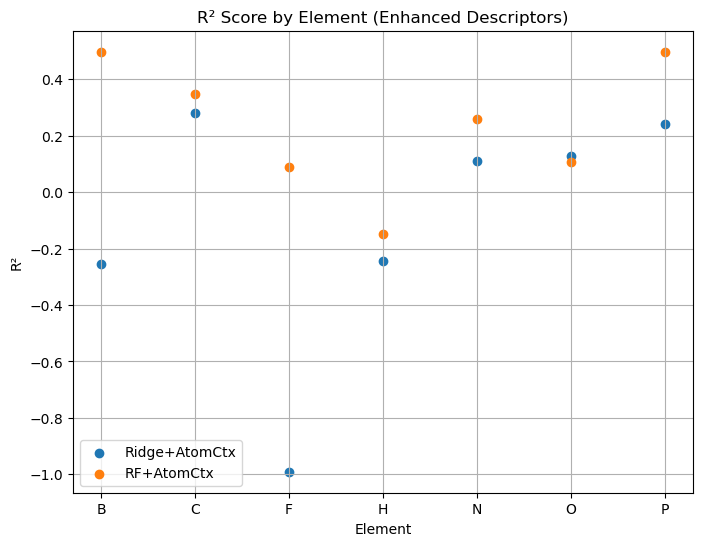

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for model in ["Ridge+AtomCtx", "RF+AtomCtx"]:
    subset = results_df[results_df["Model"] == model]
    plt.scatter(subset["Element"], subset["R2"], label=model)

plt.title("R² Score by Element (Enhanced Descriptors)")
plt.xlabel("Element")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
h_df = enhanced_df[enhanced_df["element_y"] == "H"].copy()
print("Hydrogen samples:", len(h_df))


Hydrogen samples: 241


In [14]:
import xgboost
print("XGBoost version:", xgboost.__version__)


XGBoost version: 3.0.5


In [15]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
